# Load Data

In [1]:
import sys
import os
import time

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat
import copy
from sklearn import metrics

from keras.models import Sequential  # keras==2.6.0 自动安装的2.7版本有点问题
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from keras.layers import Dropout
%matplotlib inline

# 时间序列转换为监督学习
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale original_data data to [0, 1]
def scale(original_data):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(original_data)
    # transform original_data
    data_scaled = scaler.transform(original_data)
    return scaler, data_scaled

# 反转归一化
def inverse_transform_col(scaler, y, n_col):
    """
    scaler是对包含多个feature的X拟合的,y对应其中一个feature,n_col为y在X中对应的列编号.返回y的反归一化结果
    """
    y = y.copy()
    y -= scaler.min_[n_col]
    y /= scaler.scale_[n_col]
    return y

serScada=pd.read_csv('./data/serScada.csv', index_col=0)
# 字符转标准时间索引
serScada.index = pd.to_datetime(serScada.index)
serScada


,num,wind speed(m/s),wind direction,theoretical power(kW),active power(kW)
2018-01-01 00:00:00,1,5.311336,259.994904,416.328908,380.047791
2018-01-01 00:10:00,2,5.672167,268.641113,519.917511,453.769196
2018-01-01 00:20:00,3,5.216037,272.564789,390.900016,306.376587
2018-01-01 00:30:00,4,5.659674,271.258087,516.127569,419.645905
2018-01-01 00:40:00,5,5.577941,265.674286,491.702972,380.650696
...,...,...,...,...,...
2018-12-31 23:10:00,52556,11.404030,80.502724,3397.190793,2963.980957
2018-12-31 23:20:00,52557,7.332648,84.062599,1173.055771,1684.353027
2018-12-31 23:30:00,52558,8.435358,84.742500,1788.284755,2201.106934
2018-12-31 23:40:00,52559,9.421366,84.297913,2418.382503,2515.694092


# 数据预处理

In [2]:
serScada.iloc[:,[1,2,3]]

,wind speed(m/s),wind direction,theoretical power(kW)
2018-01-01 00:00:00,5.311336,259.994904,416.328908
2018-01-01 00:10:00,5.672167,268.641113,519.917511
2018-01-01 00:20:00,5.216037,272.564789,390.900016
2018-01-01 00:30:00,5.659674,271.258087,516.127569
2018-01-01 00:40:00,5.577941,265.674286,491.702972
...,...,...,...
2018-12-31 23:10:00,11.404030,80.502724,3397.190793
2018-12-31 23:20:00,7.332648,84.062599,1173.055771
2018-12-31 23:30:00,8.435358,84.742500,1788.284755
2018-12-31 23:40:00,9.421366,84.297913,2418.382503


## 归一化或标准化

In [3]:
date_pro = serScada.iloc[:,[1,2,3]]

# 拟合计算放缩比例等参数，并存储在 scaler
scaler, data_norm = scale(date_pro)  # 字典对象也可以

data_norm

array([[0.21071704, 0.7222129 , 0.11564692],
       [0.22503231, 0.74623031, 0.14442153],
       [0.20693623, 0.75712948, 0.10858334],
       ...,
       [0.33465661, 0.23539741, 0.49674577],
       [0.37377457, 0.23416244, 0.67177292],
       [0.3959108 , 0.22854214, 0.77199558]])

In [4]:
date_pro.iloc[:5,[2]]

,theoretical power(kW)
2018-01-01 00:00:00,416.328908
2018-01-01 00:10:00,519.917511
2018-01-01 00:20:00,390.900016
2018-01-01 00:30:00,516.127569
2018-01-01 00:40:00,491.702972


<function matplotlib.pyplot.show(close=None, block=None)>

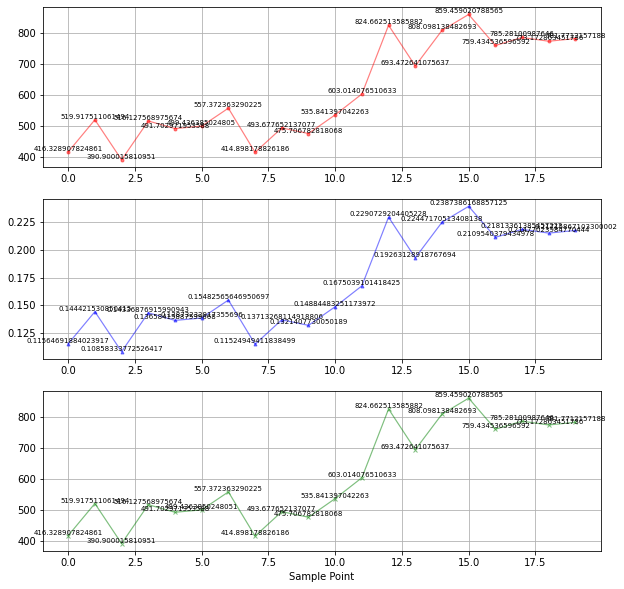

In [5]:
# 检验归一化处理是否正常
fig, axes = plt.subplots(3,1,figsize=(10,10)) # , dpi= 100

# 将配置重置为默认值
matplotlib.rcdefaults()
# plt.rcParams['font.sans-serif'] = ['Times New Roman']  # 设置中文编码'Microsoft YaHei'
# plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
# plt.rcParams['ytick.direction'] = 'in'

# 绘制原始数据
plt.subplot(311)
plt.plot(date_pro['theoretical power(kW)'][:20].values, c='r', alpha=0.5, label='原始数据', marker='o', markersize=3, linewidth=1.2)
plt.grid()  # 网格

for a, b in zip(np.array(range(0,len(date_pro['theoretical power(kW)'][:20]))), date_pro['theoretical power(kW)'][:20]):  # 设置数字标签
    plt.text(a, b, b, ha='center', va='bottom', fontsize=7)

# 绘制归一化的数据
plt.subplot(312)
plt.plot(data_norm[:,2][:20], c='b', alpha=0.5, label='normal数据', marker='^', markersize=3, linewidth=1.2)
plt.grid()  # 网格
for a, b in zip(np.array(range(0,len(data_norm[:,2][:20]))), data_norm[:,2][:20]):  # 设置数字标签
    plt.text(a, b, b, ha='center', va='bottom', fontsize=7)
    
# 绘制反转归一化的数据
plt.subplot(313)
plt.plot(inverse_transform_col(scaler, data_norm[:,2], 2)[:20], c='g', alpha=0.5, label='inverse数据', marker='x', markersize=4, linewidth=1.2)
plt.xlabel('Sample Point')
plt.grid()  # 网格
for a, b in zip(np.array(range(0,len(inverse_transform_col(scaler, data_norm[:,2], 2)[:20]))), inverse_transform_col(scaler, data_norm[:,2], 2)[:20]):  # 设置数字标签
    plt.text(a, b, b, ha='center', va='bottom', fontsize=7)

plt.show

## 序列转化为监督学习数据集

In [6]:
# to supervised learning
n_timesteps = 10  # 之前的时刻数量
n_features = data_norm.shape[1]  # 数据集中输入特征数量
data_supervised = series_to_supervised(data_norm, n_timesteps, 1)  # 包含 t 时刻之前的 timestep 个时间点，以及 t 时刻数据，以 t 时刻为预测对象

data_supervised

,var1(t-10),var2(t-10),var3(t-10),var1(t-9),var2(t-9),var3(t-9),var1(t-8),var2(t-8),var3(t-8),var1(t-7),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
10,0.210717,0.722213,0.115647,0.225032,0.746230,0.144422,0.206936,0.757129,0.108583,0.224537,...,0.115249,0.221559,0.704118,0.137133,0.219123,0.718682,0.132141,0.227093,0.699591,0.148845
11,0.225032,0.746230,0.144422,0.206936,0.757129,0.108583,0.224537,0.753500,0.143369,0.221294,...,0.137133,0.219123,0.718682,0.132141,0.227093,0.699591,0.148845,0.235428,0.737518,0.167504
12,0.206936,0.757129,0.108583,0.224537,0.753500,0.143369,0.221294,0.737989,0.136584,0.222330,...,0.132141,0.227093,0.699591,0.148845,0.235428,0.737518,0.167504,0.259756,0.761763,0.229073
13,0.224537,0.753500,0.143369,0.221294,0.737989,0.136584,0.222330,0.734946,0.138732,0.229826,...,0.148845,0.235428,0.737518,0.167504,0.259756,0.761763,0.229073,0.245963,0.740930,0.192631
14,0.221294,0.737989,0.136584,0.222330,0.734946,0.138732,0.229826,0.739348,0.154826,0.210507,...,0.167504,0.259756,0.761763,0.229073,0.245963,0.740930,0.192631,0.258089,0.741006,0.224472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,0.336143,0.221389,0.503129,0.334580,0.222592,0.496417,0.395805,0.222450,0.771529,0.413268,...,0.985875,0.495616,0.228090,0.994047,0.498261,0.223599,0.995358,0.452433,0.223620,0.943664
52556,0.334580,0.222592,0.496417,0.395805,0.222450,0.771529,0.413268,0.223480,0.840333,0.425044,...,0.994047,0.498261,0.223599,0.995358,0.452433,0.223620,0.943664,0.290909,0.233509,0.325849
52557,0.395805,0.222450,0.771529,0.413268,0.223480,0.840333,0.425044,0.224892,0.878248,0.402862,...,0.995358,0.452433,0.223620,0.943664,0.290909,0.233509,0.325849,0.334657,0.235397,0.496746
52558,0.413268,0.223480,0.840333,0.425044,0.224892,0.878248,0.402862,0.228710,0.801254,0.478761,...,0.943664,0.290909,0.233509,0.325849,0.334657,0.235397,0.496746,0.373775,0.234162,0.671773


In [7]:
# drop columns we don't want to predict
relain = np.array([3])  # array([3]) 保留第几个变量(从1计数)，即预测对象
data_supervised_droped = copy.deepcopy(data_supervised)  # 深拷贝则不会改变原始字典对象内容
remov = np.array([x for x in range(data_norm.shape[1])]) + n_timesteps*n_features  # array([30, 31, 32]) t 时刻所有参数列序号
remov = np.delete(remov,relain-1)  # array([30, 31]) 要删除的对象
data_supervised_droped.drop(data_supervised_droped.columns[remov], axis=1, inplace=True)  # 去掉输出当中不需要预测的参数列 [-1,-2,-3,-4,-5,-6]

data_supervised_droped

,var1(t-10),var2(t-10),var3(t-10),var1(t-9),var2(t-9),var3(t-9),var1(t-8),var2(t-8),var3(t-8),var1(t-7),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
10,0.210717,0.722213,0.115647,0.225032,0.746230,0.144422,0.206936,0.757129,0.108583,0.224537,...,0.210507,0.716531,0.115249,0.221559,0.704118,0.137133,0.219123,0.718682,0.132141,0.148845
11,0.225032,0.746230,0.144422,0.206936,0.757129,0.108583,0.224537,0.753500,0.143369,0.221294,...,0.221559,0.704118,0.137133,0.219123,0.718682,0.132141,0.227093,0.699591,0.148845,0.167504
12,0.206936,0.757129,0.108583,0.224537,0.753500,0.143369,0.221294,0.737989,0.136584,0.222330,...,0.219123,0.718682,0.132141,0.227093,0.699591,0.148845,0.235428,0.737518,0.167504,0.229073
13,0.224537,0.753500,0.143369,0.221294,0.737989,0.136584,0.222330,0.734946,0.138732,0.229826,...,0.227093,0.699591,0.148845,0.235428,0.737518,0.167504,0.259756,0.761763,0.229073,0.192631
14,0.221294,0.737989,0.136584,0.222330,0.734946,0.138732,0.229826,0.739348,0.154826,0.210507,...,0.235428,0.737518,0.167504,0.259756,0.761763,0.229073,0.245963,0.740930,0.192631,0.224472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,0.336143,0.221389,0.503129,0.334580,0.222592,0.496417,0.395805,0.222450,0.771529,0.413268,...,0.483839,0.228364,0.985875,0.495616,0.228090,0.994047,0.498261,0.223599,0.995358,0.943664
52556,0.334580,0.222592,0.496417,0.395805,0.222450,0.771529,0.413268,0.223480,0.840333,0.425044,...,0.495616,0.228090,0.994047,0.498261,0.223599,0.995358,0.452433,0.223620,0.943664,0.325849
52557,0.395805,0.222450,0.771529,0.413268,0.223480,0.840333,0.425044,0.224892,0.878248,0.402862,...,0.498261,0.223599,0.995358,0.452433,0.223620,0.943664,0.290909,0.233509,0.325849,0.496746
52558,0.413268,0.223480,0.840333,0.425044,0.224892,0.878248,0.402862,0.228710,0.801254,0.478761,...,0.452433,0.223620,0.943664,0.290909,0.233509,0.325849,0.334657,0.235397,0.496746,0.671773


## 划分输入\输出、训练集\测试集

In [8]:
# split into train and test sets
n_train_num = int(len(data_supervised_droped)*0.8)  # 规定训练集数据数量，要小于数据量总数，在后面设置reshape设置样本个数、时间步长要注意数量对应
train = data_supervised_droped.values[:n_train_num, :]  # 按行切片，从0到n-1行，也就是从头开始总共 n 行数据
test = data_supervised_droped.values[n_train_num:, :]  # 按行切片
# y = data_supervised_droped.values[:,n_timesteps*n_features][n_train_num:]  # 测试集的 y，用于后续结果比较

print('train 规格：', train.shape)  # train.shape[0], train.shape[1]
print('test 规格：', test.shape)  # test.shape[0], test.shape[1]

# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]  # 按列切片，从起始位置到-2列：-1列
X_test, y_test = test[:, :-1], test[:, -1]  # x 和 y 变量类型都是<class 'numpy.ndarray'>

print('X_train 规格：', X_train.shape)  # train_X.shape[0], train_X.shape[1]
print('y_train 规格：', y_train.shape)
print('X_test 规格：', X_test.shape)  # test_X.shape[0], test_X.shape[1]
print('y_test 规格：', y_test.shape)

train 规格： (42040, 31)
test 规格： (10510, 31)
X_train 规格： (42040, 30)
y_train 规格： (42040,)
X_test 规格： (10510, 30)
y_test 规格： (10510,)


## 转换为三维格式

In [9]:
# reshape input to be 3D [samples, timesteps, features] [样本数量(就是原二维矩阵行数)，时间步长，特征数量(参数种类)]
X_train = X_train.reshape((X_train.shape[0], n_timesteps, n_features))  # 相当于将每一行变换成一个二维矩阵
X_test = X_test.reshape((X_test.shape[0], n_timesteps, n_features))

print('train_X :\n', X_train, '\n')
print('X_test :\n', X_test, '\n')
print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

train_X :
 [[[0.21071704 0.7222129  0.11564692]
  [0.22503231 0.74623031 0.14442153]
  [0.20693623 0.75712948 0.10858334]
  ...
  [0.21050732 0.71653117 0.11524949]
  [0.22155942 0.70411776 0.13713268]
  [0.21912345 0.71868199 0.13214077]]

 [[0.22503231 0.74623031 0.14442153]
  [0.20693623 0.75712948 0.10858334]
  [0.22453669 0.75349973 0.14336877]
  ...
  [0.22155942 0.70411776 0.13713268]
  [0.21912345 0.71868199 0.13214077]
  [0.22709329 0.69959079 0.14884483]]

 [[0.20693623 0.75712948 0.10858334]
  [0.22453669 0.75349973 0.14336877]
  [0.22129408 0.73798907 0.13658416]
  ...
  [0.21912345 0.71868199 0.13214077]
  [0.22709329 0.69959079 0.14884483]
  [0.23542793 0.73751799 0.16750391]]

 ...

 [[0.0668358  0.24137167 0.        ]
  [0.03047629 0.19815211 0.        ]
  [0.04205116 0.22556267 0.        ]
  ...
  [0.06528268 0.2247896  0.        ]
  [0.06278808 0.30863623 0.        ]
  [0.05927546 0.41896058 0.        ]]

 [[0.03047629 0.19815211 0.        ]
  [0.04205116 0.22556267 0

# 定义LSTM并训练模型

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10800     
_________________________________________________________________
dropout (Dropout)            (None, 10, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

526/526 [==============================] - 5s 9ms/step - loss: 0.0064 - accuracy: 0.2753 - val_loss: 0.0053 - val_accuracy: 0.2569
Epoch 50/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0064 - accuracy: 0.2752 - val_loss: 0.0062 - val_accuracy: 0.2570
Epoch 51/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0065 - accuracy: 0.2752 - val_loss: 0.0052 - val_accuracy: 0.2569
Epoch 52/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0065 - accuracy: 0.2752 - val_loss: 0.0057 - val_accuracy: 0.2569
Epoch 53/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0064 - accuracy: 0.2753 - val_loss: 0.0056 - val_accuracy: 0.2569
Epoch 54/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0065 - accuracy: 0.2753 - val_loss: 0.0060 - val_accuracy: 0.2569
Epoch 55/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0065 - accuracy: 0.2753 - val_loss: 0.0058 - val_accuracy: 0.2569
Epoch

Epoch 106/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0061 - accuracy: 0.2753 - val_loss: 0.0052 - val_accuracy: 0.2569
Epoch 107/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0061 - accuracy: 0.2753 - val_loss: 0.0052 - val_accuracy: 0.2569
Epoch 108/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0061 - accuracy: 0.2753 - val_loss: 0.0052 - val_accuracy: 0.2569
Epoch 109/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0061 - accuracy: 0.2753 - val_loss: 0.0052 - val_accuracy: 0.2569
Epoch 110/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0061 - accuracy: 0.2753 - val_loss: 0.0053 - val_accuracy: 0.2569
Epoch 111/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0062 - accuracy: 0.2753 - val_loss: 0.0051 - val_accuracy: 0.2569
Epoch 112/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0061 - accuracy: 0.2753 - val_loss: 0.0053 - val_ac

526/526 [==============================] - 5s 9ms/step - loss: 0.0059 - accuracy: 0.2753 - val_loss: 0.0053 - val_accuracy: 0.2569
Epoch 163/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0059 - accuracy: 0.2753 - val_loss: 0.0053 - val_accuracy: 0.2569
Epoch 164/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0059 - accuracy: 0.2753 - val_loss: 0.0053 - val_accuracy: 0.2569
Epoch 165/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0059 - accuracy: 0.2753 - val_loss: 0.0053 - val_accuracy: 0.2569
Epoch 166/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0058 - accuracy: 0.2753 - val_loss: 0.0055 - val_accuracy: 0.2569
Epoch 167/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0058 - accuracy: 0.2753 - val_loss: 0.0053 - val_accuracy: 0.2569
Epoch 168/200
526/526 [==============================] - 5s 9ms/step - loss: 0.0058 - accuracy: 0.2753 - val_loss: 0.0053 - val_accuracy: 0.2569

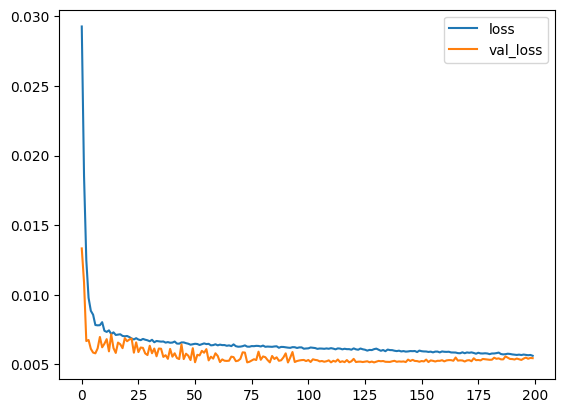

In [10]:
# define LSTM
def fit_LSTM(units=50,epochs=10):    # 神经元数目
    model = Sequential()
    # First layer
    model.add(LSTM(units = units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    # Second layer
    model.add(LSTM(units = units, return_sequences=True))
    model.add(Dropout(0.2))
    # Third layer of LSTM
    model.add(LSTM(units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    
    #Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # 生成网络结构图
    model.summary()  # 将信息打印到屏幕终端
#     tf.keras.utils.plot_model(model, show_shapes=True, to_file='./predict-wind-turbine/LSTM/LSTM结构.png', dpi=300)
    
    # set checkpoint 建立检查点，读取已有检查点存储的权重信息
#     checkpoint_save_path = "./predict-wind-turbine/LSTM/checkpoint/mnist.ckpt"  # 声明一个ckpt文件存储路径，创建checkpoint文件夹
#     if os.path.exists(checkpoint_save_path + '.index'):  # 这里判断是否之前已经存储了模型的训练信息，如果是，则为模型加载之前的参数
#         print('-------------load the model-----------------')
#         model.load_weights(checkpoint_save_path)
    
    # save model after every epoch
#     cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_save_path,
#                                                      save_weights_only = True,save_best_only = True,
#                                                      verbose=0, period=5)  # period=10, save_freq=100

    # fit network
    # 完成训练后保存到检查点, validation_data=(X_test, y_test)；verbose: 0, 1 或 2。日志显示模式。 0 = 安静模式, 1 = 进度条, 2 = 每轮一行
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split = 0.2, verbose=1,
                        shuffle=False) # , callbacks=[cp_callback]
    
    # save model
#     model.save("./predict-wind-turbine/LSTM/savedmodel")

    # plot history
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
#     plt.savefig('./predict-wind-turbine/LSTM/loss_function_LSTM.png', dpi = 300)
    plt.show()
    
    return model


time_start = time.perf_counter  ()  # 记录开始时间
model_lstm = fit_LSTM(units=50,epochs=200)
time_end = time.perf_counter  ()  # 记录结束时间

In [11]:
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print(time_sum)

986.5221029


# 预测结果

In [12]:
prediction_lstm = model_lstm.predict(X_test)
prediction_lstm = inverse_transform_col(scaler, prediction_lstm, 2)
y_test_inverse = inverse_transform_col(scaler, y_test, 2)

# 输出存储实际数据和预测结果
df_lstm = pd.DataFrame({'actual':y_test_inverse, 'predicted':prediction_lstm[:,0]})
df_lstm.to_csv('./predict-wind-turbine/compare_filter/nofilter.csv', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

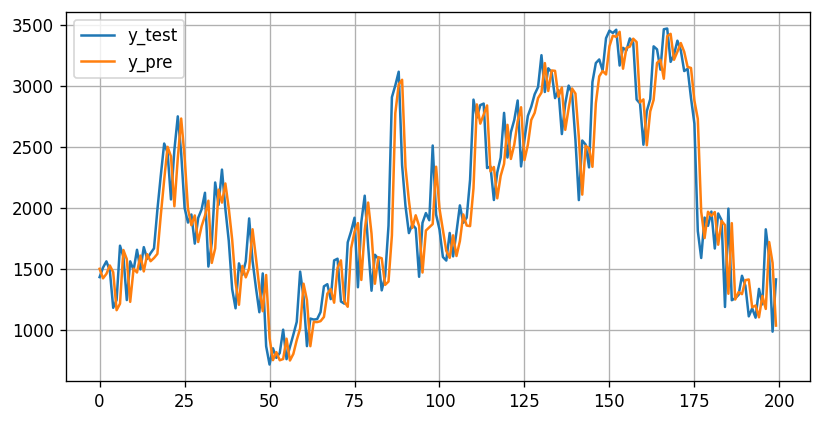

In [13]:
s, e = 300, 500
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(y_test_inverse[s:e], label='y_test')
plt.plot(prediction_lstm[s:e], label='y_pre')
plt.legend()
plt.grid()  # 网格
plt.show

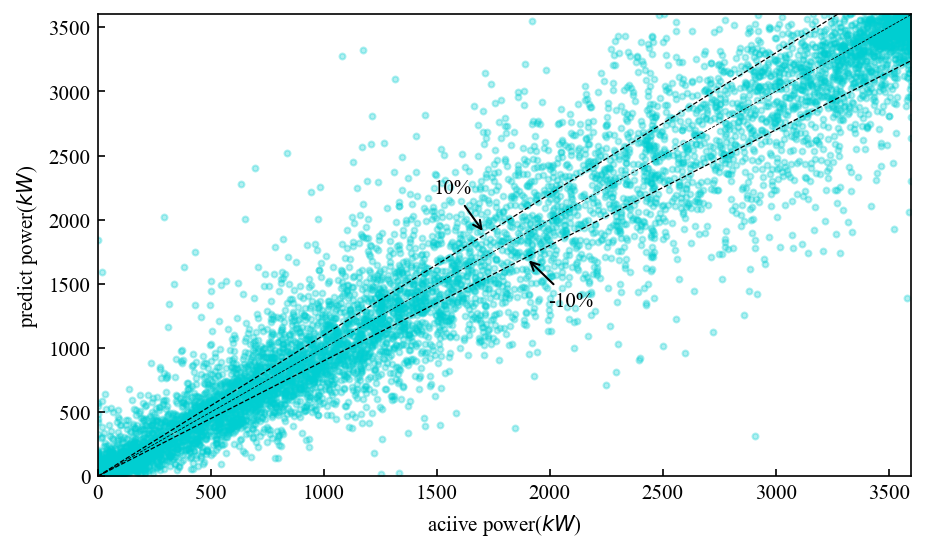

In [14]:
# 预测结果散布情况
def scatter(y1,y2):
    yy = 3600
    err = 0.1
    loc = 1800
    loc1 = (2*loc)/(2+err)
    loc2 = (2*loc)/(2-err)

    matplotlib.rcdefaults()  # 将配置重置为默认值
    plt.rcParams['font.sans-serif']=['Times New Roman']  # 设置中文编码微软雅黑SimHei
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
    plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
    plt.rcParams['ytick.direction'] = 'in'

    colors = ['#00CED1', '#DC143C']  #点的颜色
    plt.figure(figsize=(7, 4), dpi=150)
    area = 8  # 点面积 
    plt.xlabel("aciive power($kW$)")
    plt.ylabel("predict power($kW$)")
    plt.xlim(xmin = 0,xmax = yy)
    plt.ylim(ymin = 0,ymax = yy)

    plt.scatter(y1, y2, s=area, c=colors[0], alpha=0.3, label='类别A')
    plt.plot([0,yy],[0,yy],linewidth = '0.4',color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy+yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')
    plt.plot([0,yy],[0,yy-yy*err], linewidth = '0.6', color='#000000', linestyle='dashed')

    plt.annotate(str(int(err*100))+'%', xy=(loc1, loc1+loc1*err), xytext=(loc1-230, loc1+loc1*err+320),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )
    plt.annotate(str(int(-1*err*100))+'%', xy=(loc2, loc2-loc2*err), xytext=(loc2+100, loc2-loc2*err-380),
                arrowprops=dict(arrowstyle='->', facecolor='black')
                )

    # plt.legend(loc='upper right')  # 显示图例["第一个","第二个"],
    
    
scatter(y_test_inverse,prediction_lstm)
# plt.savefig(r'./predict-wind-turbine/LSTM/lstm预测散布.png', dpi=300)
plt.show()